In [1]:
from src.utils import *
from pathlib import Path
from nltk.probability import FreqDist
from src.preprocess import clean_tokens, date_to_astral, ASTRAL_DATES
from matplotlib import pyplot as plt
from wordcloud import WordCloud
from pathlib import Path
import pandas as pd
import numpy as np
from functools import reduce
import pickle
from scipy import stats

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pierr\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Path for spacy/stanza data 
DOCS_PATH = Path(f'data/lg/spacy.pkl')

In [3]:
docs = pickle.loads(DOCS_PATH.read_bytes())

In [4]:
df = pd.DataFrame(docs, columns=['path', 'birthDate', 'birthPlace', 'deathDate'])
df.head()

,path,birthDate,birthPlace,deathDate
0,http://dbpedia.org/resource/Captain_Raju,1950-06-27,http://dbpedia.org/resource/Travancore-Cochin,2018-09-17
1,http://dbpedia.org/resource/Gerd_Audehm,1968-08-14,http://dbpedia.org/resource/Bezirk_Cottbus,None
2,http://dbpedia.org/resource/Saana_Saarteinen,1993-02-11,http://dbpedia.org/resource/Finland_Fed_Cup_team,None
3,http://dbpedia.org/resource/Melymel_(rapper),1988-05-06,http://dbpedia.org/resource/Santo_Domingo,None
4,http://dbpedia.org/resource/Samuel_Adler_(rabbi),1809-12-03,"http://dbpedia.org/resource/Worms,_Germany",1891-06-09


In [5]:
df['astral_sign'] = df.birthDate.apply(date_to_astral)
df.head()

,path,birthDate,birthPlace,deathDate,astral_sign
0,http://dbpedia.org/resource/Captain_Raju,1950-06-27,http://dbpedia.org/resource/Travancore-Cochin,2018-09-17,Cancer
1,http://dbpedia.org/resource/Gerd_Audehm,1968-08-14,http://dbpedia.org/resource/Bezirk_Cottbus,None,Leo
2,http://dbpedia.org/resource/Saana_Saarteinen,1993-02-11,http://dbpedia.org/resource/Finland_Fed_Cup_team,None,Aquarius
3,http://dbpedia.org/resource/Melymel_(rapper),1988-05-06,http://dbpedia.org/resource/Santo_Domingo,None,Taurus
4,http://dbpedia.org/resource/Samuel_Adler_(rabbi),1809-12-03,"http://dbpedia.org/resource/Worms,_Germany",1891-06-09,Sagittarius


In [6]:
df.describe()

,path,birthDate,birthPlace,deathDate,astral_sign
count,16978,16978,16978,6007,16978
unique,16978,14287,7532,5614,12
top,http://dbpedia.org/resource/Captain_Raju,1981-09-11,http://dbpedia.org/resource/United_States,2020-04-12,Aquarius
freq,1,6,158,4,1463


In [7]:
df['astral_sign'].value_counts()

Aquarius       1463
Capricorn      1459
Gemini         1456
Pisces         1447
Aries          1445
Virgo          1435
Scorpio        1431
Cancer         1420
Libra          1409
Taurus         1406
Leo            1349
Sagittarius    1258
Name: astral_sign, dtype: int64

In [8]:
df['birthYear'] = df.birthDate.apply(lambda x: int(x[:4]))

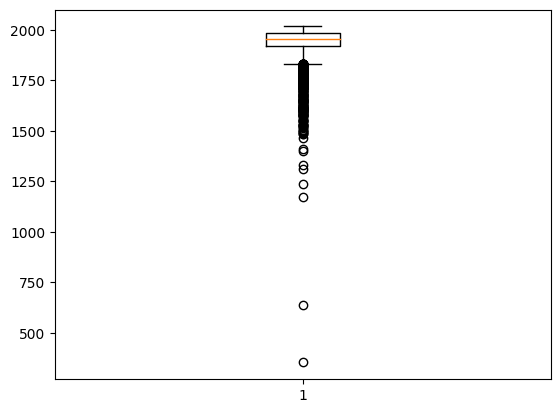

In [9]:
plt.boxplot(df.birthYear)
plt.savefig('figures/boxplot_birth.pdf')

In [10]:
df.birthYear.describe()

count    16978.000000
mean      1941.586406
std         59.165331
min        354.000000
25%       1921.000000
50%       1956.000000
75%       1982.000000
max       2016.000000
Name: birthYear, dtype: float64

In [11]:
cleaner = clean_tokens(keep_lemma=False, remove_month=False)
df[['abstract_tokens', 'page_tokens']] = [(cleaner(doc['abstract']), cleaner(doc['page'])) for doc in docs]
df.head()

c:\Users\pierr\.conda\envs\data-td\lib\site-packages\numpy\core\fromnumeric.py:3156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


,path,birthDate,birthPlace,deathDate,astral_sign,birthYear,abstract_tokens,page_tokens
0,http://dbpedia.org/resource/Captain_Raju,1950-06-27,http://dbpedia.org/resource/Travancore-Cochin,2018-09-17,Cancer,1950,"[raju, daniel, june, september, known, stage, ...","[raju, daniel, june, september, known, stage, ..."
1,http://dbpedia.org/resource/Gerd_Audehm,1968-08-14,http://dbpedia.org/resource/Bezirk_Cottbus,None,Leo,1968,"[gerd, audehm, born, august, schipkau, bezirk,...","[gerd, audehm, born, august, schipkau, bezirk,..."
2,http://dbpedia.org/resource/Saana_Saarteinen,1993-02-11,http://dbpedia.org/resource/Finland_Fed_Cup_team,None,Aquarius,1993,"[saana, saarteinen, born, february, finnish, t...","[saana, saarteinen, born, february, finnish, t..."
3,http://dbpedia.org/resource/Melymel_(rapper),1988-05-06,http://dbpedia.org/resource/Santo_Domingo,None,Taurus,1988,"[melymel, mermelada, born, may, santo, domingo...","[melymel, mermelada, born, may, santo, domingo..."
4,http://dbpedia.org/resource/Samuel_Adler_(rabbi),1809-12-03,"http://dbpedia.org/resource/Worms,_Germany",1891-06-09,Sagittarius,1809,"[samuel, adler, december, june, leading, germa...","[samuel, adler, december, june, leading, germa..."


In [13]:
# Work only for spacy parser

df['abstract_len'] = df['abstract_tokens'].apply(len)
df['page_len'] = df['page_tokens'].apply(len)
df['abstract_sent_len'] = [len(list(doc['abstract'].sents)) for doc in docs]
df['page_sent_len'] = [len(list(doc['page'].sents)) for doc in docs]

In [14]:
df[['abstract_len', 'page_len', 'abstract_sent_len', 'page_sent_len']].describe()

,abstract_len,page_len,abstract_sent_len,page_sent_len
count,16978.000000,16978.000000,16978.000000,16978.000000
mean,37.551537,306.385970,3.502061,27.974143
std,39.979845,506.473747,3.592945,43.975608
min,4.000000,4.000000,1.000000,1.000000
25%,14.000000,65.000000,1.000000,7.000000
50%,24.000000,161.000000,2.000000,15.000000
75%,44.000000,348.000000,4.000000,32.000000
max,516.000000,12912.000000,45.000000,935.000000


In [15]:
df.groupby('astral_sign')[['abstract_len', 'abstract_sent_len']].describe()

abstract_len                                                      \
                   count       mean        std  min   25%   50%   75%    max   
astral_sign                                                                    
Aquarius          1463.0  36.860560  38.290287  4.0  14.0  24.0  42.0  293.0   
Aries             1445.0  36.788235  37.318139  5.0  14.0  23.0  45.0  365.0   
Cancer            1420.0  38.397183  39.633504  6.0  15.0  24.0  45.0  330.0   
Capricorn         1459.0  37.269363  38.241249  4.0  14.0  24.0  44.0  421.0   
Gemini            1456.0  36.094780  36.704213  6.0  14.0  23.0  42.0  329.0   
Leo               1349.0  38.990363  44.892196  5.0  14.0  23.0  45.0  511.0   
Libra             1409.0  39.145493  42.743214  4.0  15.0  24.0  44.0  416.0   
Pisces            1447.0  36.576365  41.493466  5.0  14.0  23.0  41.0  516.0   
Sagittarius       1258.0  36.877583  37.620823  6.0  15.0  24.0  45.0  431.0   
Scorpio           1431.0  37.419986  37.610337  5.0  15.0  24.0  45.0  290.0   
Taurus            1406.0  36.897582  39.961327  4.0  14.0  23.0  41.0  324.0   
Virgo             1435.0  39.381185  44.317091  5.0  15.0  25.0  46.0  412.0   

            abstract_sent_len                                                
                        count      mean       std  min  25%  50%  75%   max  
astral_sign                                                                  
Aquarius               1463.0  3.397129  3.393309  1.0  1.0  2.0  4.0  27.0  
Aries                  1445.0  3.446367  3.378387  1.0  1.0  2.0  4.0  32.0  
Cancer                 1420.0  3.561268  3.467118  1.0  1.0  2.0  4.0  29.0  
Capricorn              1459.0  3.504455  3.449689  1.0  1.0  2.0  4.0  30.0  
Gemini                 1456.0  3.359890  3.273492  1.0  1.0  2.0  4.0  29.0  
Leo                    1349.0  3.586360  3.879604  1.0  1.0  2.0  4.0  42.0  
Libra                  1409.0  3.643719  3.884441  1.0  1.0  2.0  4.0  41.0  
Pisces                 1447.0  3.465100  3.815777  1.0  1.0  2.0  4.0  45.0  
Sagittarius            1258.0  3.432432  3.398343  1.0  1.0  2.0  4.0  40.0  
Scorpio                1431.0  3.517820  3.660152  1.0  1.0  2.0  4.0  33.0  
Taurus                 1406.0  3.463016  3.640967  1.0  1.0  2.0  4.0  35.0  
Virgo                  1435.0  3.650871  3.810549  1.0  1.0  2.0  4.0  42.0

In [16]:
df.groupby('astral_sign')[['page_len', 'page_sent_len']].describe()

page_len                                                      \
               count        mean         std   min    25%    50%     75%   
astral_sign                                                                
Aquarius      1463.0  311.360902  481.298628   7.0  63.50  170.0  361.00   
Aries         1445.0  321.201384  565.667861   9.0  64.00  161.0  361.00   
Cancer        1420.0  313.488732  513.770765  10.0  62.00  166.0  351.00   
Capricorn     1459.0  283.422207  455.530604   7.0  63.00  152.0  327.50   
Gemini        1456.0  300.927198  455.204855   9.0  65.75  165.0  348.00   
Leo           1349.0  316.497405  526.729482   8.0  66.00  152.0  363.00   
Libra         1409.0  295.872960  440.666492   4.0  63.00  156.0  336.00   
Pisces        1447.0  310.409122  496.305553   9.0  69.00  165.0  360.00   
Sagittarius   1258.0  295.291733  477.475165  10.0  60.00  157.0  346.75   
Scorpio       1431.0  290.670860  453.490287   9.0  71.00  166.0  337.00   
Taurus        1406.0  293.576814  474.234302   9.0  65.00  158.0  332.00   
Virgo         1435.0  342.960976  684.101514   7.0  66.00  172.0  373.00   

                     page_sent_len                                        \
                 max         count       mean        std  min  25%   50%   
astral_sign                                                                
Aquarius      6472.0        1463.0  28.287765  42.615048  1.0  7.0  16.0   
Aries         8476.0        1445.0  29.889965  53.456532  1.0  6.0  16.0   
Cancer        5813.0        1420.0  28.830986  45.929991  1.0  7.0  16.0   
Capricorn     5588.0        1459.0  25.875942  39.007830  1.0  6.0  14.0   
Gemini        5551.0        1456.0  27.442995  40.053909  1.0  7.0  16.0   
Leo           6197.0        1349.0  28.765752  45.456781  1.0  7.0  15.0   
Libra         4943.0        1409.0  26.985806  38.098535  1.0  7.0  15.0   
Pisces        7279.0        1447.0  28.404976  43.808481  1.0  7.0  16.0   
Sagittarius   9226.0        1258.0  27.430843  44.268927  1.0  6.0  15.0   
Scorpio       7921.0        1431.0  26.818309  38.486495  1.0  7.0  16.0   
Taurus        6286.0        1406.0  26.682077  40.129478  1.0  7.0  15.0   
Virgo        12912.0        1435.0  30.236237  52.994177  1.0  7.0  16.0   

                          
              75%    max  
astral_sign               
Aquarius     33.0  591.0  
Aries        32.0  856.0  
Cancer       32.0  614.0  
Capricorn    29.0  489.0  
Gemini       32.0  554.0  
Leo          33.0  611.0  
Libra        31.0  435.0  
Pisces       33.0  548.0  
Sagittarius  30.0  897.0  
Scorpio      31.0  491.0  
Taurus       31.0  588.0  
Virgo        33.0  935.0

abstract_len    AxesSubplot(0.125,0.11;0.775x0.77)
dtype: object

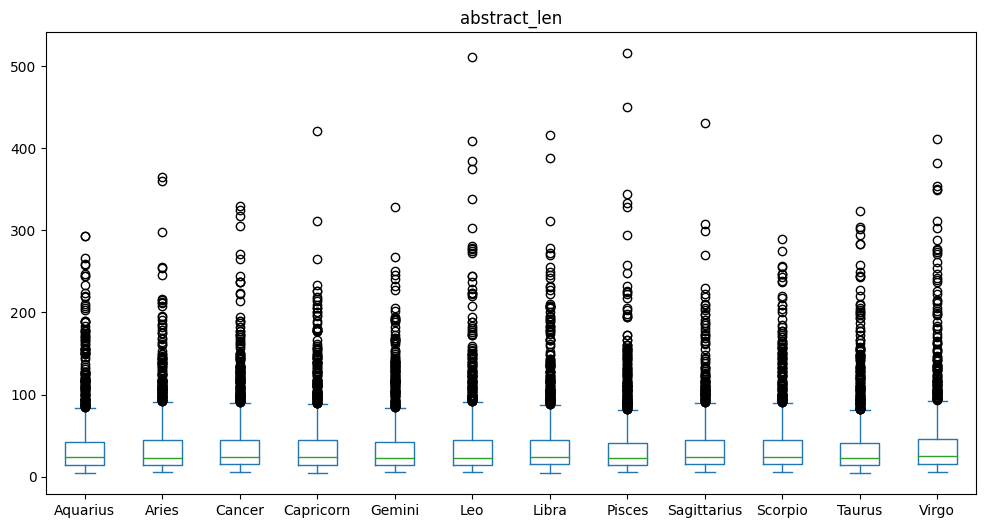

In [17]:
df[['astral_sign', 'abstract_len']].plot.box('astral_sign', figsize=(12,6))

In [18]:
import matplotlib.pyplot as plt

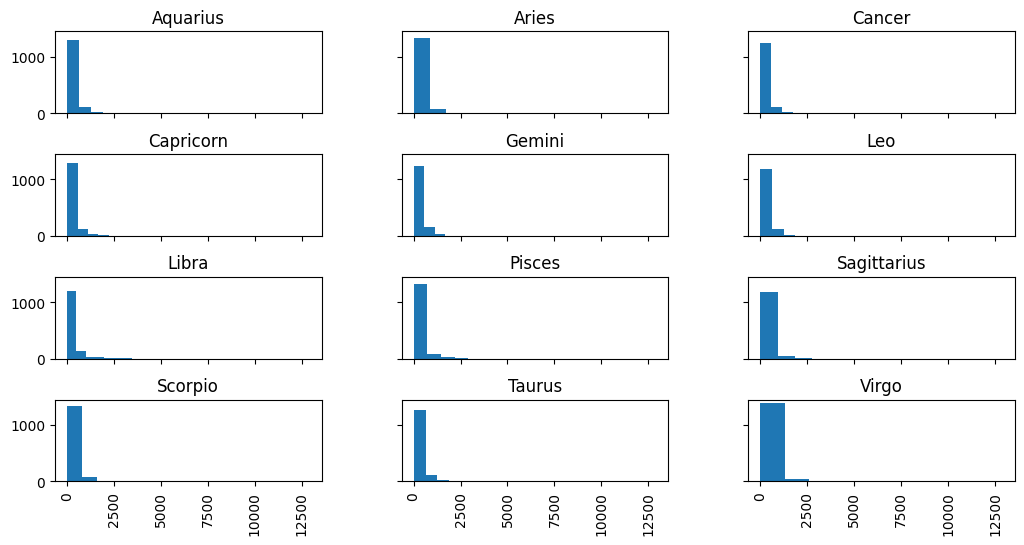

In [19]:
ax = df[['astral_sign', 'page_len']].hist(column='page_len', by='astral_sign', sharex=True, sharey=True, figsize=(12,6))

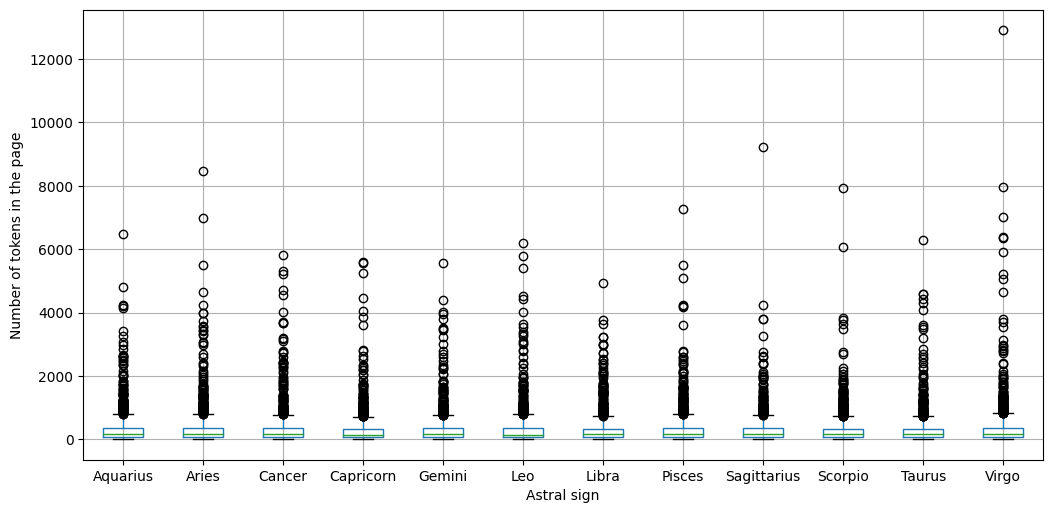

In [20]:
ax = df[['astral_sign', 'page_len']].boxplot(column='page_len', by='astral_sign', figsize=(12,6))
ax.set_xlabel(xlabel='Astral sign')
ax.set_ylabel(ylabel='Number of tokens in the page')
# ax.set_title('Distribution of the number of tokens in a page per astral sign')
ax.set_title(None)
fig = ax.get_figure()
fig.suptitle(None)
fig.savefig('figures/boxplot_page_len.pdf')

abstract_sent_len    AxesSubplot(0.125,0.11;0.775x0.77)
dtype: object

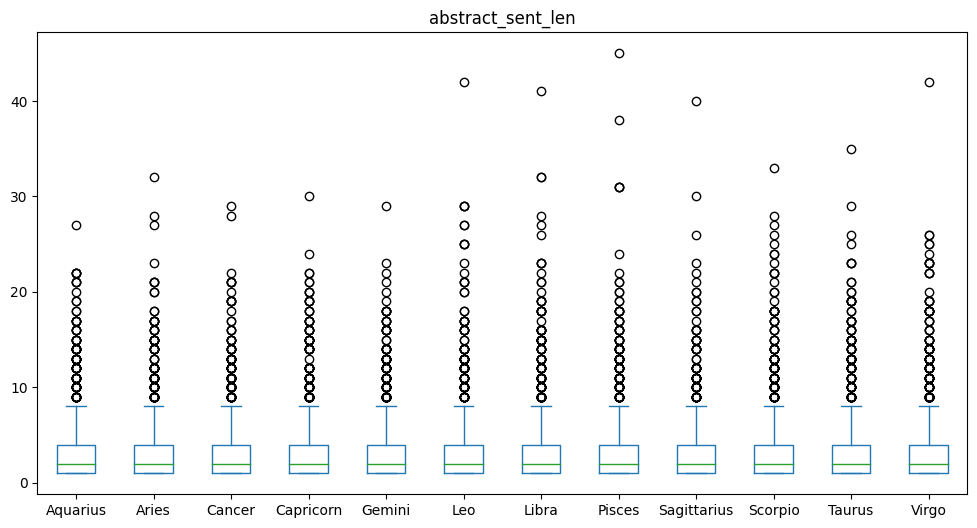

In [21]:
df[['astral_sign', 'abstract_sent_len']].plot.box('astral_sign', figsize=(12,6))

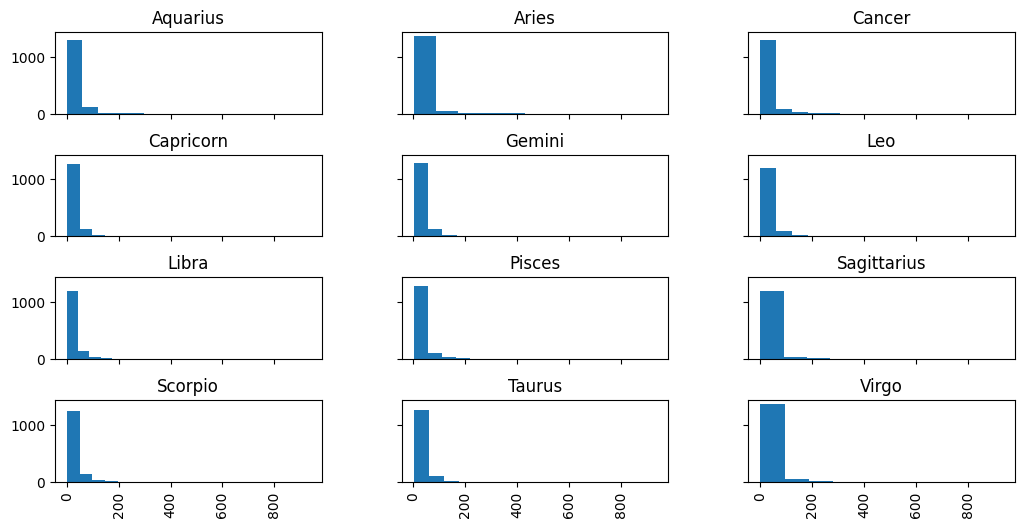

In [22]:
ax = df[['astral_sign', 'page_sent_len']].hist(column='page_sent_len', by='astral_sign', sharex=True, sharey=True, figsize=(12,6))

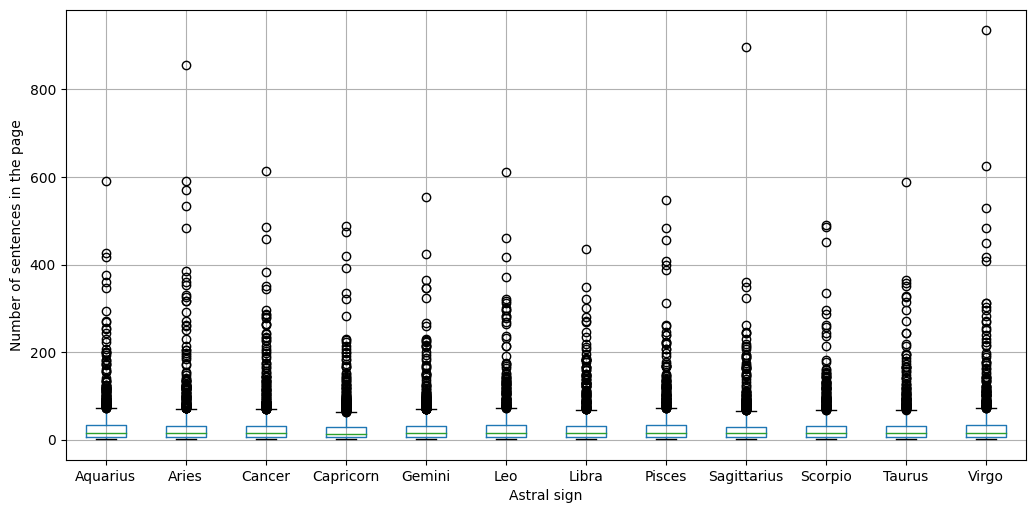

In [23]:
ax = df[['astral_sign', 'page_sent_len']].boxplot(column='page_sent_len', by='astral_sign', figsize=(12,6))
ax.set_xlabel(xlabel='Astral sign')
ax.set_ylabel(ylabel='Number of sentences in the page')
# ax.set_title('Distribution of the number of sentences in a page per astral sign')
ax.set_title(None)
fig = ax.get_figure()
fig.suptitle(None)
fig.savefig('figures/boxplot_page_sent_len.pdf')

In [24]:
def compute_freqs(df, target):
    freqs = {}
    for sign in df['astral_sign'].sort_values().unique():
        freqs[sign] = FreqDist(reduce(lambda a, b: a + b, df[df['astral_sign'] == sign][target], []))
    return freqs

def make_wordclouds(freqs):
    wc = WordCloud(background_color="white", max_words=50, contour_width=3, contour_color='steelblue')
    fig = plt.figure(figsize=(12,9))
    tmp = {}
    for i, freq in enumerate(freqs.items()):
        sign, freq = freq
        tmp[sign] = wc.generate_from_frequencies(freq)
        fig.add_subplot(4,3,i+1)
        plt.imshow(tmp[sign])
        plt.title(sign)
    return fig

In [25]:
abstract_freqs = compute_freqs(df, 'abstract_tokens')

In [26]:
page_freqs = compute_freqs(df, 'page_tokens')

In [27]:
page_freqs.keys()

dict_keys(['Aquarius', 'Aries', 'Cancer', 'Capricorn', 'Gemini', 'Leo', 'Libra', 'Pisces', 'Sagittarius', 'Scorpio', 'Taurus', 'Virgo'])

In [28]:
common_words = None
for k,v in page_freqs.items():
    if common_words == None:
        common_words = {w for w, _ in v.most_common(50)}
    else:
        common_words = common_words.intersection({w for w, _ in v.most_common(50)})
print(len(common_words), common_words)

33 {'united', 'school', 'served', 'year', 'life', 'links', 'american', 'career', 'international', 'league', 'world', 'years', 'state', 'new', 'season', 'member', 'made', 'born', 'film', 'would', 'references', 'played', 'team', 'external', 'second', 'first', 'work', 'club', 'time', 'early', 'university', 'became', 'national'}


In [29]:
for common_word in common_words:
    print(common_word)

united
school
served
year
life
links
american
career
international
league
world
years
state
new
season
member
made
born
film
would
references
played
team
external
second
first
work
club
time
early
university
became
national


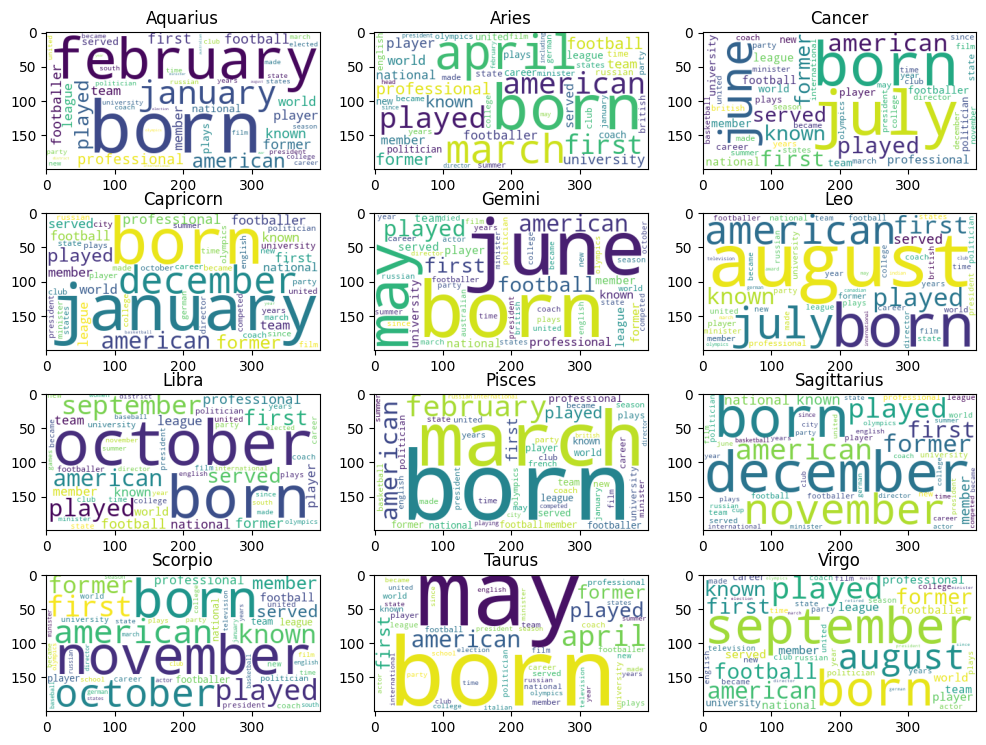

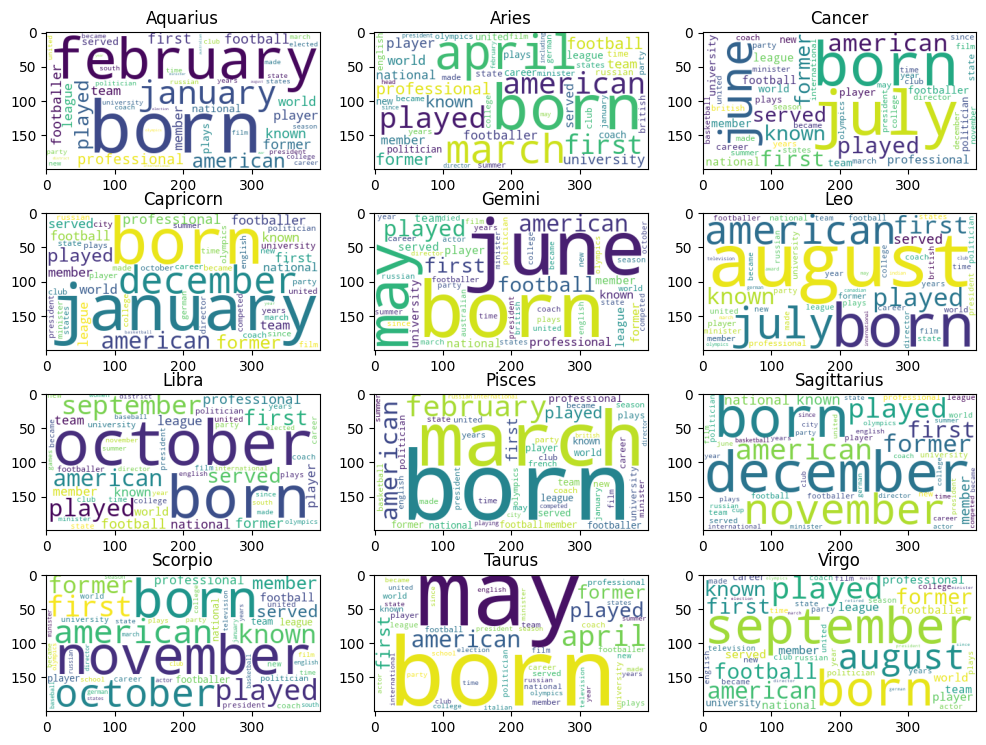

In [30]:
make_wordclouds(abstract_freqs)

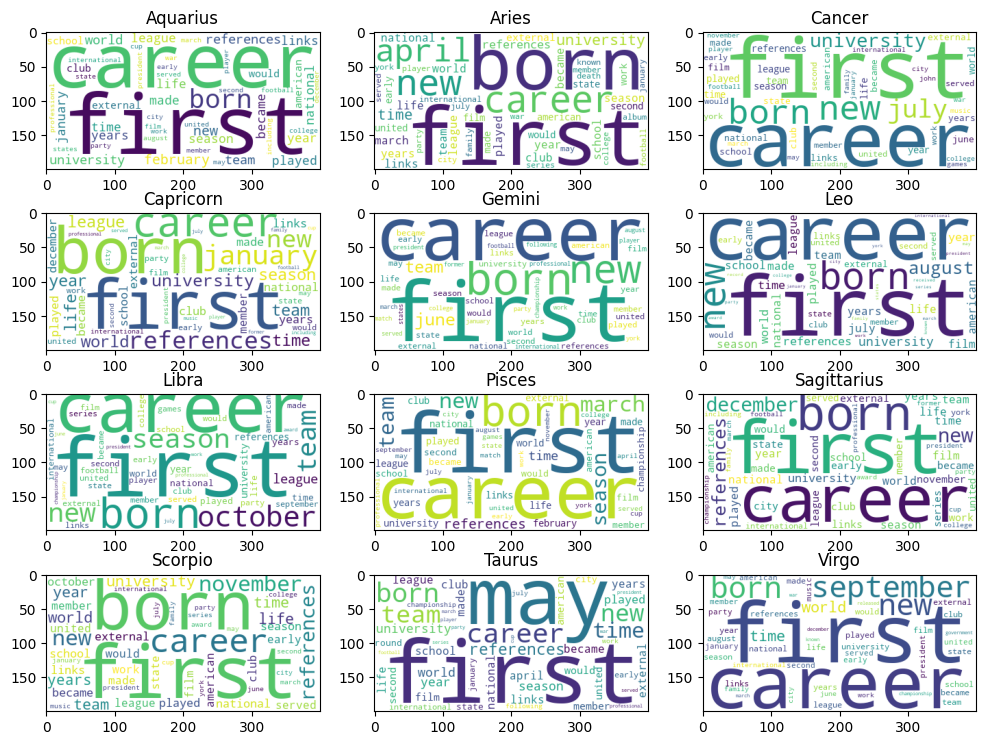

In [31]:
fig = make_wordclouds(page_freqs)
fig.savefig(f'figures/wordcloud_page_freqs.pdf')

## Statistical tests

In [33]:
stats.shapiro(df.loc[df['astral_sign']=='Taurus', ['page_len']])

ShapiroResult(statistic=0.5086815357208252, pvalue=0.0)

In [34]:
#Tests the normality of the distribution
df[['astral_sign', 'page_len']].groupby('astral_sign').apply(lambda x: stats.shapiro(x))

astral_sign
Aquarius       (0.5506218671798706, 0.0)
Aries          (0.4740526080131531, 0.0)
Cancer         (0.5115237236022949, 0.0)
Capricorn      (0.5085588693618774, 0.0)
Gemini         (0.5579885244369507, 0.0)
Leo            (0.5075070858001709, 0.0)
Libra          (0.5814732313156128, 0.0)
Pisces          (0.520249605178833, 0.0)
Sagittarius    (0.5019378662109375, 0.0)
Scorpio         (0.509660005569458, 0.0)
Taurus         (0.5086815357208252, 0.0)
Virgo          (0.3930683135986328, 0.0)
dtype: object

In [35]:
#Tests the homogeneity of the variances
b= [df[df['astral_sign']==v]['page_len'].values for v in df['astral_sign'].unique()]
stats.bartlett(*b)

BartlettResult(statistic=535.1112013917154, pvalue=1.0325805156860506e-107)

In [36]:
#Tests the population median
k= [df[df['astral_sign']==v]['page_len'].values for v in df['astral_sign'].unique()]
stats.kruskal(*k)

KruskalResult(statistic=7.313922524130097, pvalue=0.773121494435395)